In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
from simple_detector import *
from advanced_detector import CameraPipeline
from imageio import imwrite 

In [3]:
import logging
logging.basicConfig()
format_ = '%(asctime) - %(message)s'
logger = logging.getLogger('test')
logger.setLevel(logging.DEBUG)

In [4]:
# calibration n test cases
calibration_folder = 'camera_cal'
test_cases = 'test_images'

# Testing

In [5]:
from advanced_detector import hls_select
test_set = glob.glob(test_cases + '/*.jpg')

# Filtering

In [116]:
from advanced_detector import color_filter

In [138]:
test_set

['test_images/test3.jpg',
 'test_images/test5.jpg',
 'test_images/test1.jpg',
 'test_images/test6.jpg',
 'test_images/straight_lines2.jpg',
 'test_images/test4.jpg',
 'test_images/test2.jpg',
 'test_images/straight_lines1.jpg']

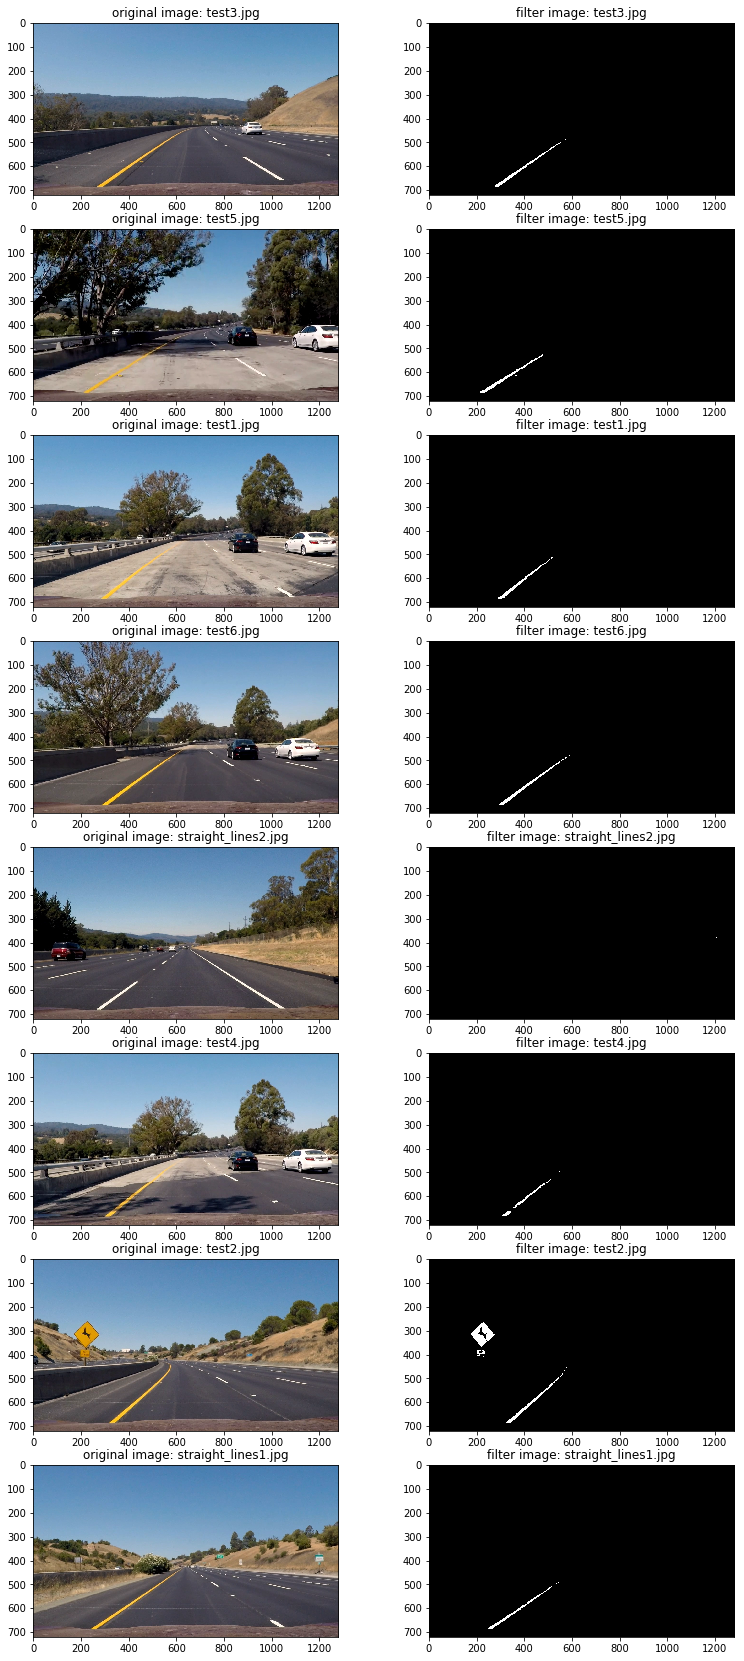

In [157]:
test_length = len(test_set)
plt.figure(figsize=(13,60))
hfd = 0.65

counter = 0
for image in test_set:
    
    img_name = image.split('/')[1]
    img, img_size = read_video(image)
    
    merg = color_filter(image = img, lower = np.array([200,120,0]), 
                        upper = np.array([255,255, 100])) #, colourspace=cv2.COLOR_BGR2RGB )
    #print('filter summary stats: min {0} max {1} mean {2} shape {3}'.format(np.min(merg), np.max(merg), 
    #                                                              np.mean(merg), merg.shape ) )
    
    binary = np.zeros_like(img[:,:,0])
    binary[(merg >= 1)] = 1
    #print('binary summary stats: min {0} max {1} mean {2}'.format(np.min(binary), np.max(binary), 
    #                                                              np.mean(binary) ) )
    
    
    plt.subplot(test_length*2,2,counter+1)
    plt.title('original image: {0}'.format(img_name))
    plt.imshow(img) #, cmap='gray', interpolation='none')
    
    plt.subplot(test_length*2,2,counter+2)
    plt.title('filter image: {0}'.format(img_name))
    plt.imshow(binary, cmap='gray', interpolation='none')
    
    counter +=2
    #savepath = os.path.join('output_images', 'filtered' + img_name)

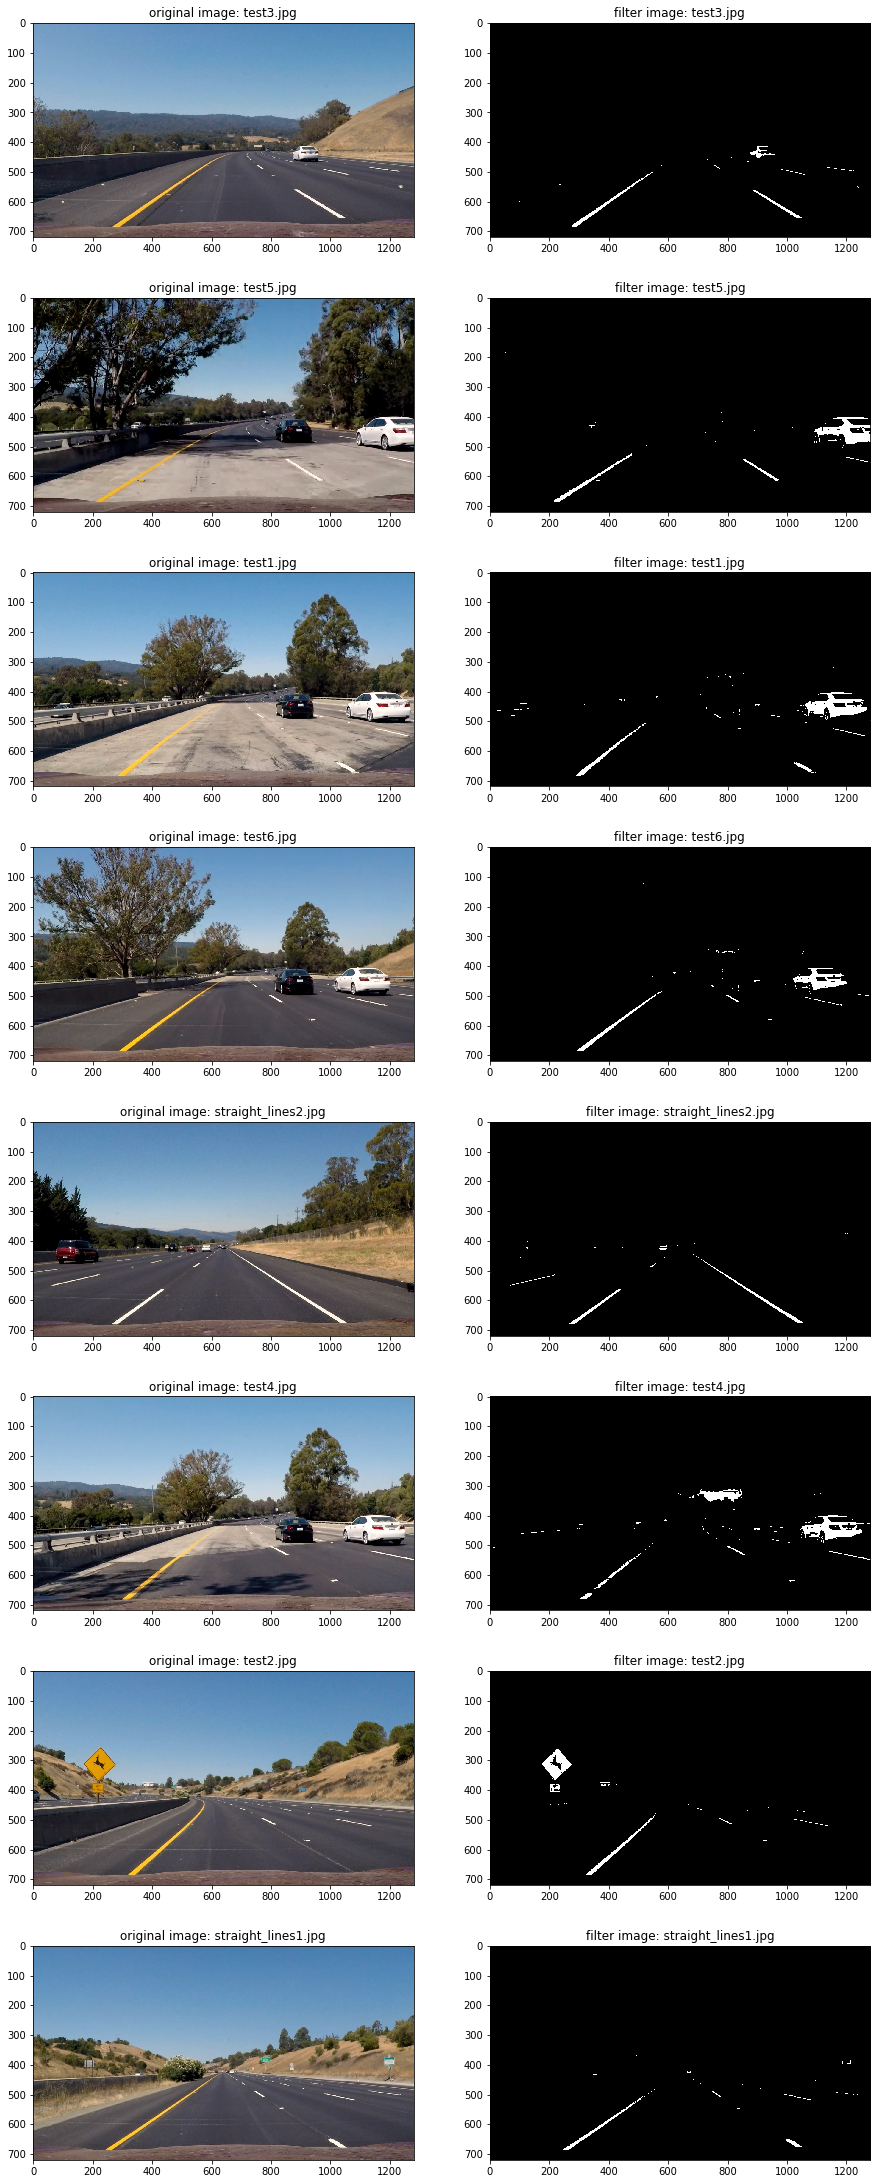

In [212]:
# check filtering
from advanced_detector import filter_image

test_length = len(test_set)
plt.figure(figsize=(15,80))
hfd = 0.65
    
counter = 0
for image in test_set:
    
    img_name = image.split('/')[1]
    img, img_size = read_video(image)
    
    merg = filter_image(img) 
    
    plt.subplot(test_length*2,2,counter+1)
    plt.title('original image: {0}'.format(img_name))
    plt.imshow(img) #, cmap='gray', interpolation='none')
    
    plt.subplot(test_length*2,2,counter+2)
    plt.title('filter image: {0}'.format(img_name))
    plt.imshow(merg, cmap='gray', interpolation='none')
    
    counter +=2
    savepath = os.path.join('output_images', 'filtered' + img_name)
    #imwrite(savepath, merg.astype(np.uint8))

# Pipeline Development

Testing pipeline to work out how to perspective transform image

In [164]:
def testing_pipeline(img_path, how_far_down):
    
    result, fr_shape = read_video(img_path)
    
    hls = cv2.cvtColor(result, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    
    #proc_f = grayscale(result)
    proc_f = gaussian_blur(S, 5)
    proc_f = canny(proc_f, 30, 255)
    roi = region_of_interest(proc_f, np.array([[(0.1*fr_shape[1],fr_shape[0]),
                                            (fr_shape[1]*0.95, fr_shape[0]), 
                                            (0.55*fr_shape[1], how_far_down*fr_shape[0]), 
                                            (0.45*fr_shape[1],how_far_down*fr_shape[0])]], dtype=np.int32))
    proc_f_lines = hough_lines(roi, 4, np.pi/180, 16, 5, 400)
    if proc_f_lines is not None:
        final_lines = find_lines(proc_f, proc_f_lines)
        #logger.debug('{0} lines'.format(final_lines))
    
        corner_points = find_points_for_transform(final_lines, result)
        logger.debug('image:{0} corner points:{1}'.format(img_path, corner_points))
        
        output_img = draw_lines(proc_f, final_lines, margin = 90)
        output_img = weighted_img(output_img, result)

    else:
        output_img = result
        
    return output_img, corner_points

DEBUG:test:image:test_images/test5.jpg corner points:[[227, 687, 585, 468], [910, 574, 973, 613]]


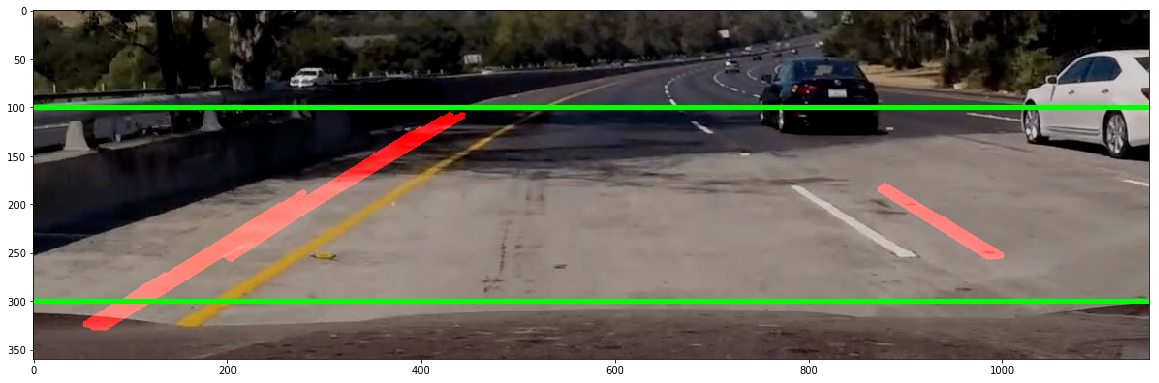

In [165]:
test_length = len(test_set)
plt.figure(figsize=(20,50))
hfd = 0.65
side_margin = 0.05
for i in range(1, 2):

    output_img, corners = testing_pipeline(test_set[i], hfd)
    
    output_shape = output_img.shape
    
    car_forward_region = output_img[int(output_shape[0]/2):output_shape[0],
                                    int(output_shape[1]*side_margin):int(output_shape[1]*(1-side_margin)) ]
    
    # drawing some lines to find an ideal crop to take to create the perspective warp
    cv2.line(car_forward_region, (0,100),(car_forward_region.shape[1],100),[0,255,0], 3)
    cv2.line(car_forward_region, (0,300),(car_forward_region.shape[1],300),[0,255,0], 3)
    
    #plt.subplot(test_length,2,i+1)
    plt.imshow(car_forward_region, cmap='gray', interpolation='none')

In [166]:
# it's not working right but lets do the perspective transform and other bits first
img_size = car_forward_region.shape

src = np.float32([[445, 150], [760, 150], [150,300], [1100,300]])
dst = np.float32([[190, 150], [1055, 150], [150,300], [1100,300]])

In [167]:
# hardcoded perspective transform
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(car_forward_region, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR) 

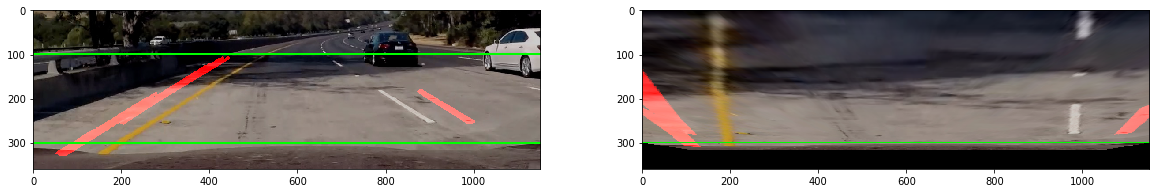

In [168]:
plt.figure(figsize=(20,50))
plt.subplot(1,2,1)
plt.imshow(car_forward_region, cmap='gray') 
plt.subplot(1,2,2)
plt.imshow(warped, cmap='gray') 

In [169]:
from imageio import imwrite
imwrite(os.path.join('output_images', 'prewarp.jpg'), car_forward_region)
imwrite(os.path.join('output_images', 'postwarp.jpg'), warped)

# Distort and run the window on merged image

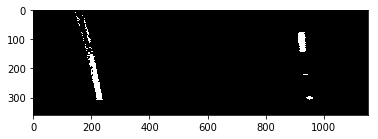

In [170]:
merged_car_region = merg[int(output_shape[0]/2):output_shape[0],
                                    int(output_shape[1]*side_margin):int(output_shape[1]*(1-side_margin)) ]
img_size = merged_car_region.shape
warped = cv2.warpPerspective(merged_car_region, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap='gray') 

In [171]:
# try exercise code
from advanced_detector import find_lane_pixels, fit_polynomial, measure_curvature_pixels, calc_bias

In [179]:
left_fit, right_fit, left_fit_pts, right_fit_pts, ploty = fit_polynomial(warped, None, None)
#plt.imshow(out_img)

### Curvature & Offset Calcs

In [181]:
left_curve, right_curve = measure_curvature_pixels(warped, left_fit, right_fit)

In [182]:
print('left curve: {0}, right curve: {1}'.format(left_curve, right_curve) )

left curve: 1114.2684089890122, right curve: 1084.3234376241346


In [183]:
bias = calc_bias(warped, left_fit_pts, right_fit_pts)
print('bias (-ve is right drift): {:.2f}m'.format(bias))

bias (-ve is right drift): -0.20m


# Calibrate Image First

In [184]:
cal_images = glob.glob(calibration_folder + '/*.jpg')

In [200]:
process_cam = CameraPipeline(9,6)
process_cam.calibrate_cam(cal_images)

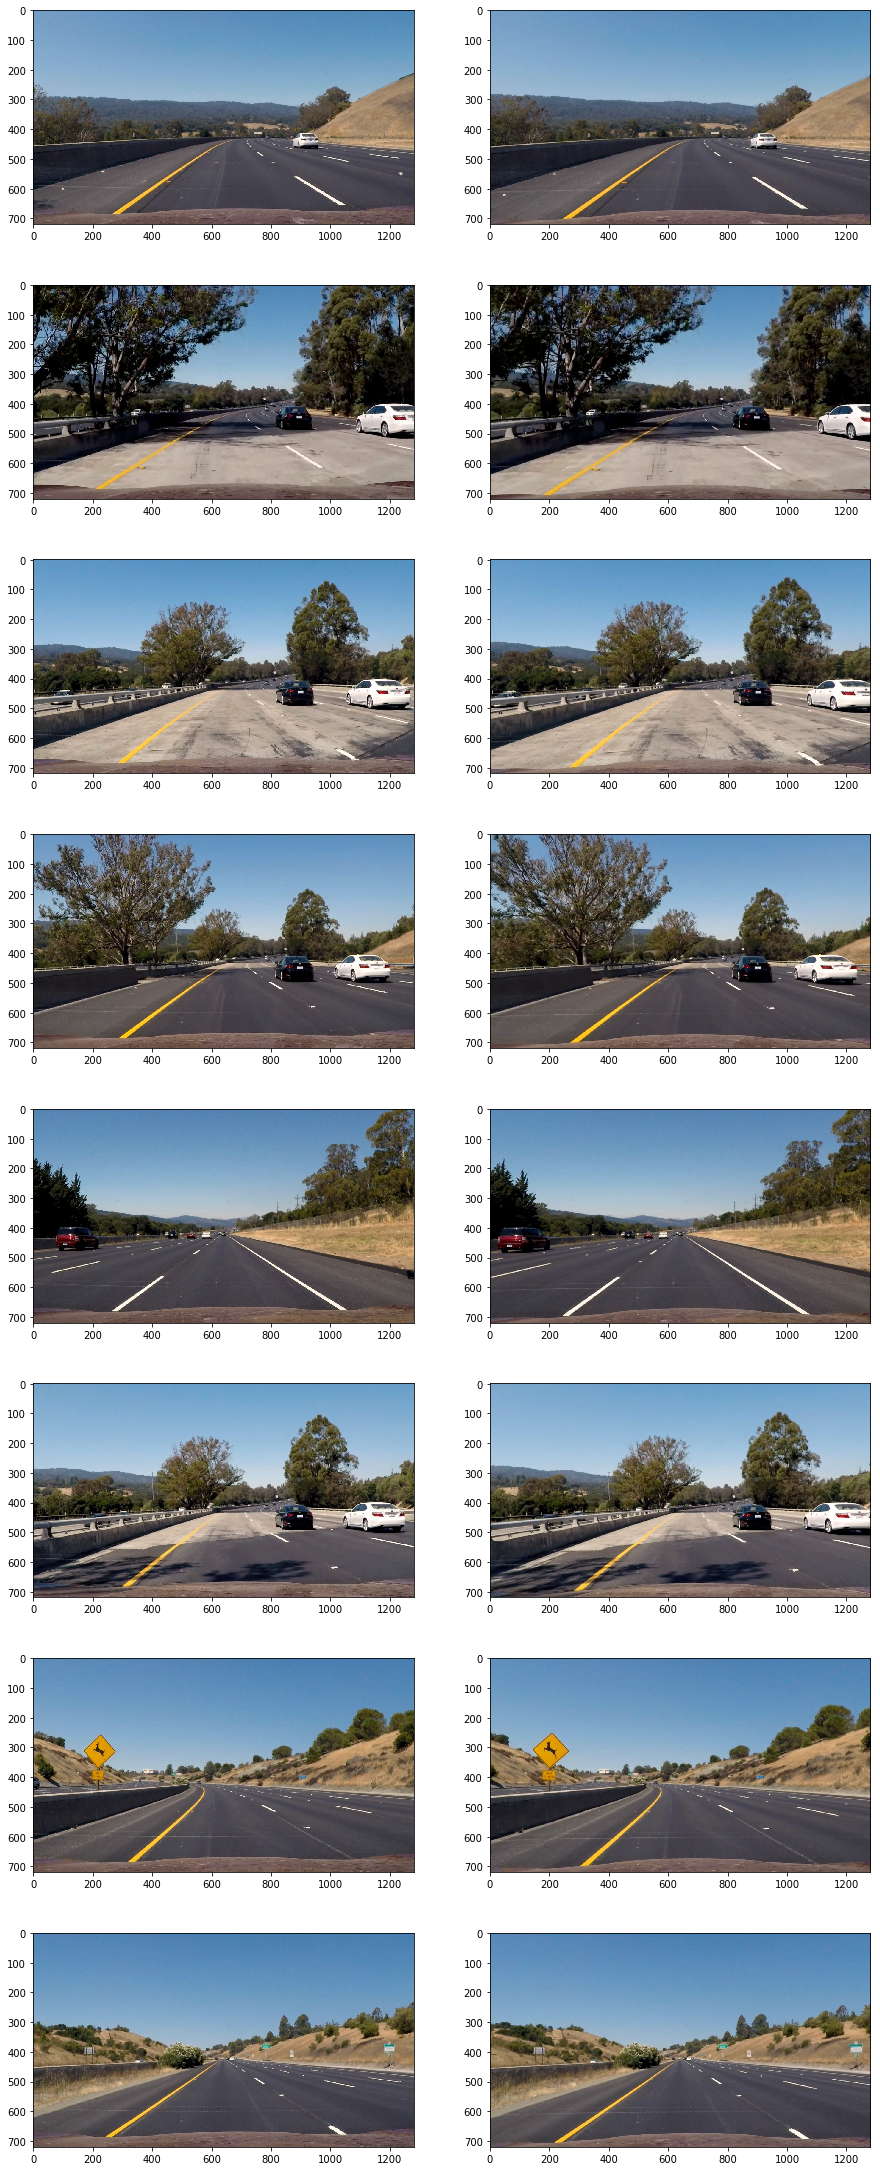

In [213]:
from advanced_detector import undistort_img
# test the calibration by undistorting
test_length = len(test_set)
plt.figure(figsize=(15,80))
for i in range(0, test_length):
    #logger.info(print(test_pack[i]))
    img_name = test_set[i].split('/')[1]
    
    img, size = read_video(test_set[i])
    result = undistort_img(img, process_cam.objpoints, process_cam.imgpoints)    
    
    plt.subplot(test_length*2,2,i*2+1)
    plt.imshow(img, interpolation='none')
    plt.subplot(test_length*2,2,i*2+2)
    plt.imshow(result, interpolation='none')
    
    # name
    output_name = 'undist_' + img_name
    savepath = os.path.join('output_images', output_name)
    
    imwrite(savepath, result.astype(np.uint8))

# Filter

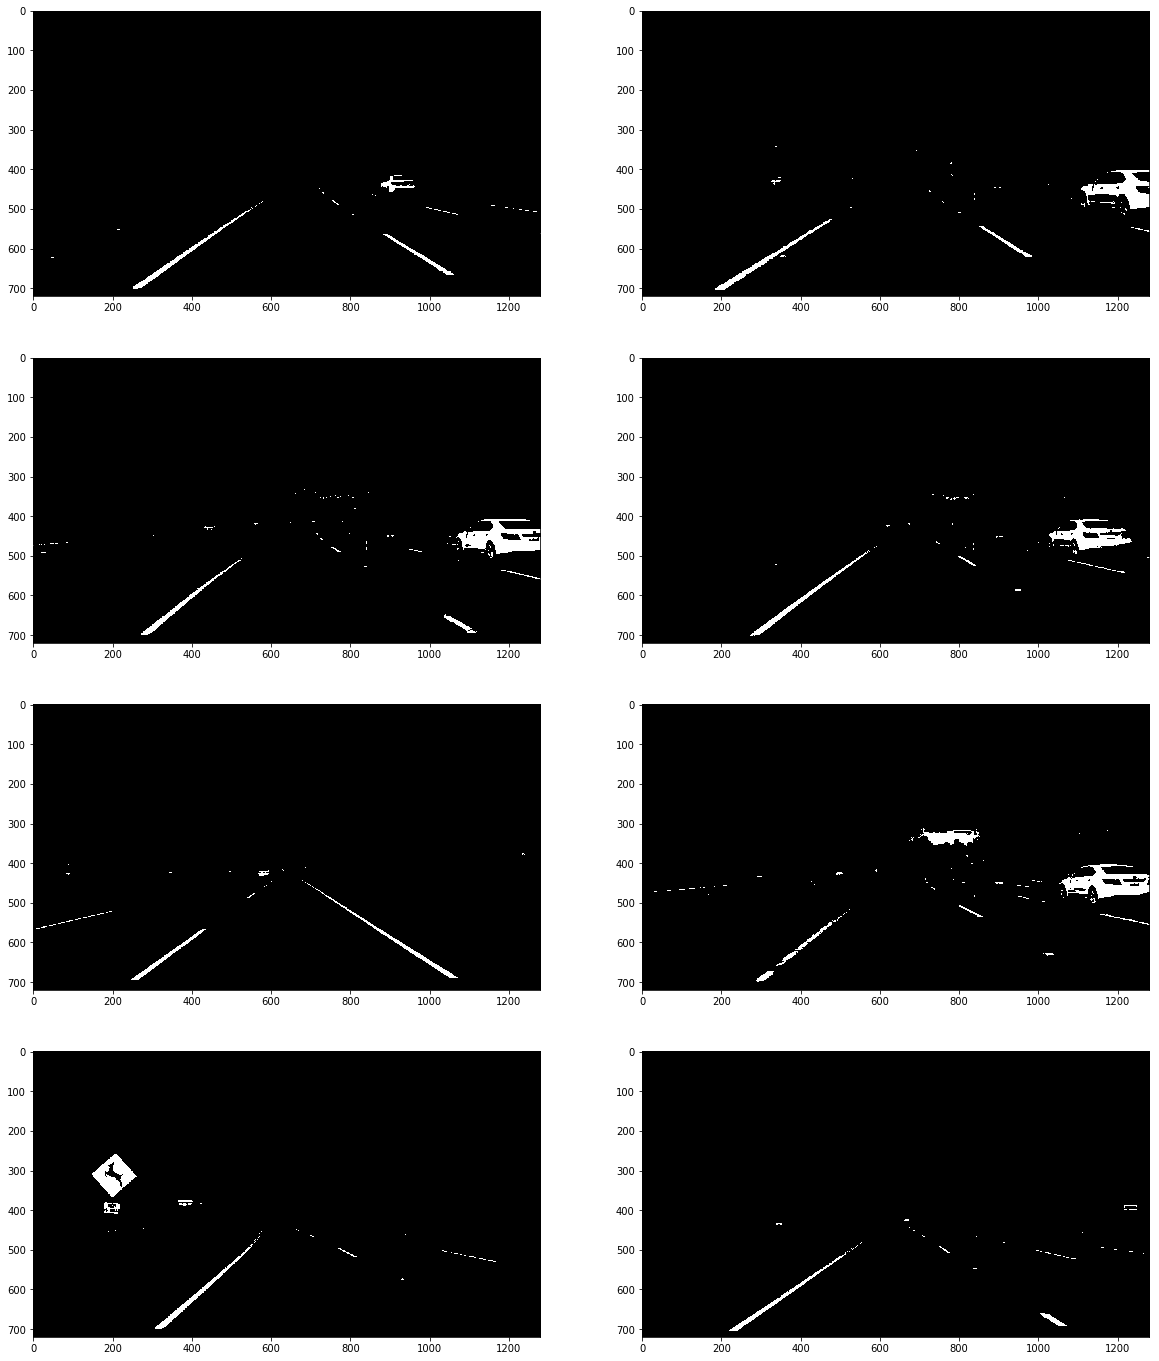

In [214]:

test_length = len(test_set)
plt.figure(figsize=(20,50))
hfd = 0.65
for i in range(0, test_length):

    img_name = test_set[i].split('/')[1]
    
    img, img_size = read_video(test_set[i])
    result = undistort_img(img, process_cam.objpoints, process_cam.imgpoints)
    
    merg = filter_image(result)
    
    plt.subplot(test_length,2,i+1)
    plt.imshow(merg, cmap='gray', interpolation='none')
    
    savepath = os.path.join('output_images', 'filtered_' + img_name)
    imwrite(savepath, merg)

# Run on Test

In [189]:
test_set = glob.glob(test_cases + '/*.jpg')

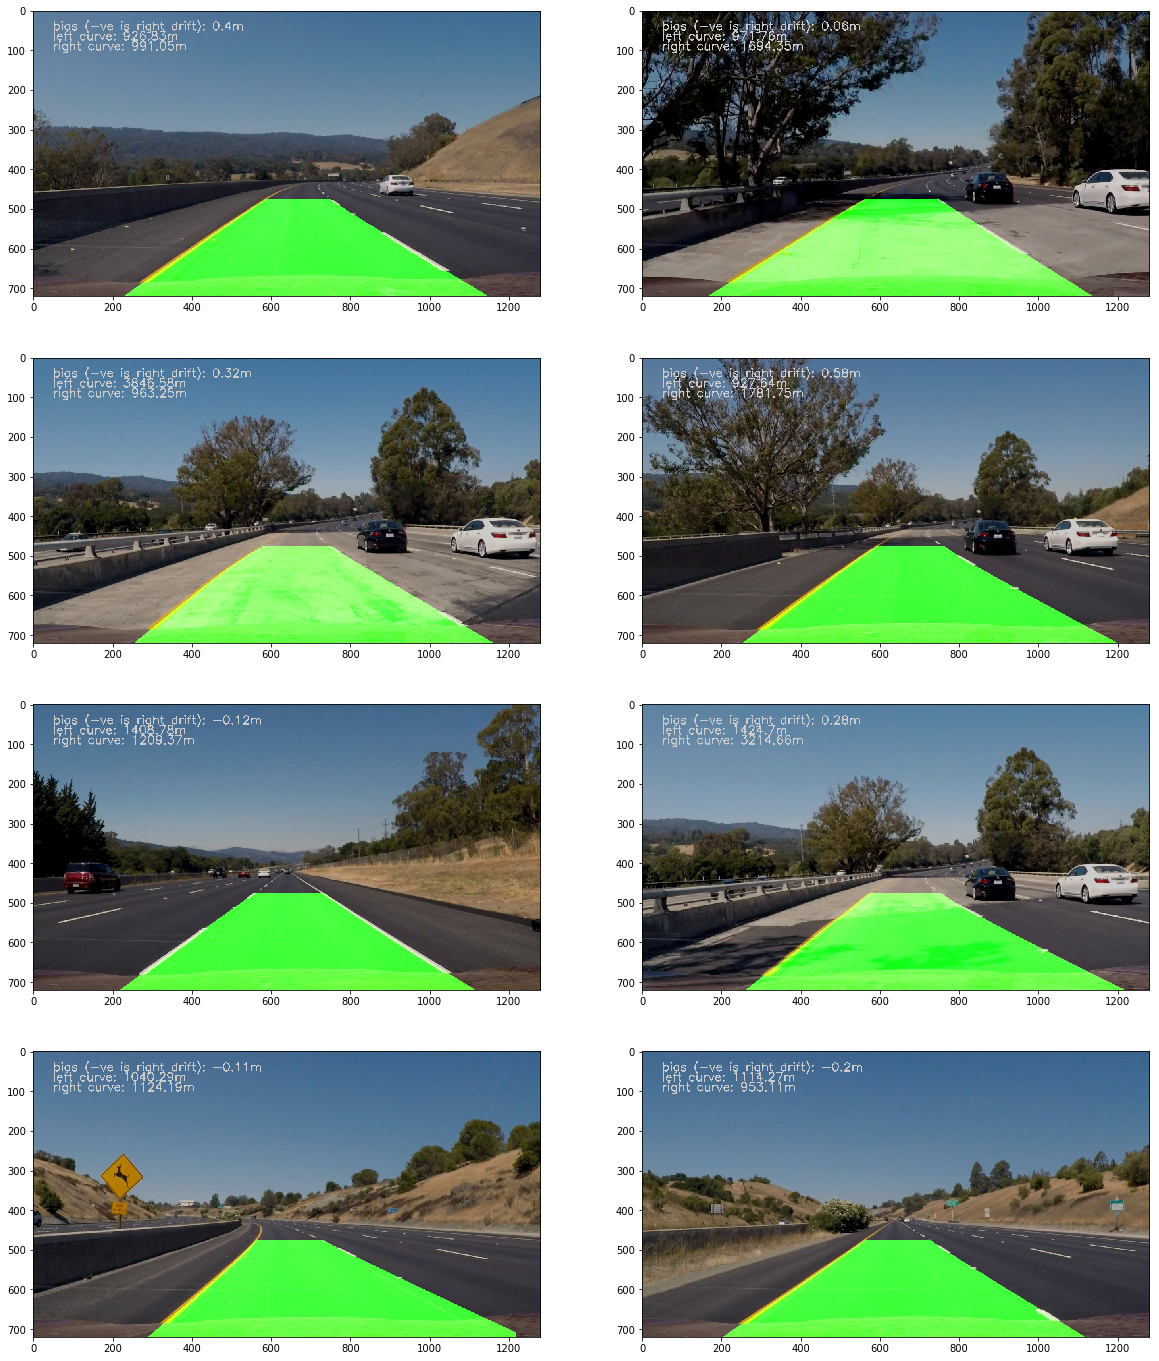

In [215]:
test_length = len(test_set)
plt.figure(figsize=(20,50))
for i in range(0, test_length):
    #logger.info(print(test_pack[i]))
    img_name = test_set[i].split('/')[1]
    
    result = process_cam.process(test_set[i], 0)    
    
    plt.subplot(test_length,2,i+1)
    plt.imshow(result, cmap='gray', interpolation='none')
    
    savepath = os.path.join('output_images', 'final_' + img_name)
    imwrite(savepath, merg.astype(np.uint8))

# Test on Video

In [194]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [202]:
# reset detector in case
process_cam = CameraPipeline(9,6)
process_cam.calibrate_cam(cal_images)

In [203]:
output = 'project_processed_video.mp4'
clip = VideoFileClip('project_video.mp4')

In [204]:
def process_filter(image):
    result = filter_image(img)
    assert type(result) == np.ndarray
    frame = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)
    return frame

In [205]:
def process_image(image):
    result = process_cam.process(image)
    return result

In [206]:
image_clip = clip.fl_image(process_image)
%time image_clip.write_videofile(output, audio=False)


                                                                  
t:  83%|████████▎ | 1049/1260 [6:17:50<00:05, 40.30it/s, now=None]A
                                                                  
t:  83%|████████▎ | 1049/1260 [6:17:50<00:05, 40.30it/s, now=None]A

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

t:   0%|          | 5/1260 [00:00<00:27, 46.02it/s, now=None]

Moviepy - Building video project_processed_video.mp4.
Moviepy - Writing video project_processed_video.mp4





t:   1%|          | 11/1260 [00:00<00:26, 48.04it/s, now=None]

t:   1%|▏         | 16/1260 [00:00<00:26, 47.58it/s, now=None]

t:   2%|▏         | 22/1260 [00:00<00:24, 49.62it/s, now=None]

t:   2%|▏         | 27/1260 [00:00<00:25, 49.22it/s, now=None]

t:   3%|▎         | 33/1260 [00:00<00:24, 51.08it/s, now=None]

t:   3%|▎         | 39/1260 [00:00<00:23, 51.44it/s, now=None]

t:   4%|▎         | 45/1260 [00:00<00:23, 52.31it/s, now=None]

t:   4%|▍         | 50/1260 [00:00<00:24, 49.05it/s, now=None]

t:   4%|▍         | 56/1260 [00:01<00:24, 49.96it/s, now=None]

t:   5%|▍         | 61/1260 [00:01<00:24, 48.76it/s, now=None]

t:   5%|▌         | 66/1260 [00:01<00:24, 48.18it/s, now=None]

t:   6%|▌         | 71/1260 [00:01<00:24, 47.88it/s, now=None]

t:   6%|▌         | 76/1260 [00:01<00:24, 47.67it/s, now=None]

t:   6%|▋         | 81/1260 [00:01<00:25, 46.31it/s, now=None]

t:   7%|▋         | 86/1260 [00:01<00:25, 46.46it/s, now=None]

t:   7%|▋         | 91/1260 [00:01<00:

t:  48%|████▊     | 606/1260 [00:12<00:14, 45.03it/s, now=None]

t:  48%|████▊     | 611/1260 [00:13<00:14, 45.85it/s, now=None]

t:  49%|████▉     | 616/1260 [00:13<00:13, 46.16it/s, now=None]

t:  49%|████▉     | 621/1260 [00:13<00:13, 46.25it/s, now=None]

t:  50%|████▉     | 626/1260 [00:13<00:13, 46.48it/s, now=None]

t:  50%|█████     | 631/1260 [00:13<00:13, 45.33it/s, now=None]

t:  50%|█████     | 636/1260 [00:13<00:13, 45.64it/s, now=None]

t:  51%|█████     | 641/1260 [00:13<00:13, 46.06it/s, now=None]

t:  51%|█████▏    | 646/1260 [00:13<00:13, 46.29it/s, now=None]

t:  52%|█████▏    | 651/1260 [00:13<00:13, 46.56it/s, now=None]

t:  52%|█████▏    | 656/1260 [00:14<00:13, 45.90it/s, now=None]

t:  52%|█████▏    | 661/1260 [00:14<00:12, 46.48it/s, now=None]

t:  53%|█████▎    | 666/1260 [00:14<00:12, 46.71it/s, now=None]

t:  53%|█████▎    | 671/1260 [00:14<00:12, 45.66it/s, now=None]

t:  54%|█████▎    | 676/1260 [00:14<00:12, 45.04it/s, now=None]

t:  54%|█████▍    | 681/1

t:  94%|█████████▍| 1184/1260 [00:25<00:01, 47.95it/s, now=None]

t:  94%|█████████▍| 1189/1260 [00:25<00:01, 47.56it/s, now=None]

t:  95%|█████████▍| 1194/1260 [00:25<00:01, 47.85it/s, now=None]

t:  95%|█████████▌| 1199/1260 [00:25<00:01, 48.36it/s, now=None]

t:  96%|█████████▌| 1204/1260 [00:25<00:01, 48.71it/s, now=None]

t:  96%|█████████▌| 1209/1260 [00:25<00:01, 47.98it/s, now=None]

t:  96%|█████████▋| 1214/1260 [00:26<00:00, 46.71it/s, now=None]

t:  97%|█████████▋| 1219/1260 [00:26<00:00, 46.94it/s, now=None]

t:  97%|█████████▋| 1224/1260 [00:26<00:00, 46.58it/s, now=None]

t:  98%|█████████▊| 1229/1260 [00:26<00:00, 47.47it/s, now=None]

t:  98%|█████████▊| 1234/1260 [00:26<00:00, 47.00it/s, now=None]

t:  98%|█████████▊| 1239/1260 [00:26<00:00, 46.76it/s, now=None]

t:  99%|█████████▊| 1244/1260 [00:26<00:00, 46.24it/s, now=None]

t:  99%|█████████▉| 1249/1260 [00:26<00:00, 46.06it/s, now=None]

t: 100%|█████████▉| 1254/1260 [00:26<00:00, 46.04it/s, now=None]

t: 100%|██

Moviepy - Done !
Moviepy - video ready project_processed_video.mp4
CPU times: user 3min 49s, sys: 2.29 s, total: 3min 52s
Wall time: 27.5 s


In [208]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))